In [1]:
import pandas as pd
import os
from pathlib import Path
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
import sys
from plotnine import *
from mizani.formatters import percent_format

In [2]:
path = Path(os.getcwd())

In [3]:
base_dir = path.parent.parent

In [4]:
data_in = os.path.join(str(base_dir) , "da_data_repo/hotels-vienna/clean/")

In [5]:
data_out = os.path.join(str(base_dir), "da_case_studies/ch10-hotels-multiple-reg/")

In [6]:
func = os.path.join(str(base_dir) ,   "da_case_studies/ch00-tech-prep/")

In [7]:
sys.path.append(func)

In [8]:
from py_helper_functions import *

In [9]:
hotels = pd.read_csv(os.path.join(data_in,"hotels-vienna.csv"))

In [10]:
hotels = hotels.query('accommodation_type=="Hotel"'). \
       query('city_actual=="Vienna"'). \
       query('stars>=3 & stars<=4'). \
       query('price<=600')

In [11]:
hotels = hotels[hotels['stars'].notnull()]

In [12]:
len(hotels)

207

In [13]:
hotels['lnprice']=hotels['price'].map(lambda x:np.log(x))

In [14]:
hotels['distance2']=hotels['distance']

In [15]:
hotels.loc[hotels['distance2']<0.05,'distance2']=0.05

In [16]:
hotels['lndistance']=hotels['distance2'].map(lambda x:np.log(x))

In [17]:
hotels['star35']=(hotels['stars']==3.5).map(int)

In [18]:
hotels['star4']=(hotels['stars']==4).map(int)

In [19]:
hotels['price'].describe()

count    207.000000
mean     109.975845
std       42.221381
min       50.000000
25%       82.000000
50%      100.000000
75%      129.500000
max      383.000000
Name: price, dtype: float64

In [20]:
hotels['distance'].describe()

count    207.000000
mean       1.529952
std        1.161507
min        0.000000
25%        0.800000
50%        1.300000
75%        1.900000
max        6.600000
Name: distance, dtype: float64

In [21]:
hotels['lnprice'].describe()

count    207.000000
mean       4.640219
std        0.336751
min        3.912023
25%        4.406719
50%        4.605170
75%        4.863673
max        5.948035
Name: lnprice, dtype: float64

In [22]:
reg0 = smf.ols('lnprice ~ rating', data=hotels).fit()
reg1 = smf.ols('lnprice ~ distance', data=hotels).fit()
reg2 = smf.ols('lnprice ~ distance + rating', data=hotels).fit()

In [23]:
print(reg0.summary())

                            OLS Regression Results                            
Dep. Variable:                lnprice   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     69.11
Date:                Thu, 15 Apr 2021   Prob (F-statistic):           1.28e-14
Time:                        13:20:17   Log-Likelihood:                -37.850
No. Observations:                 207   AIC:                             79.70
Df Residuals:                     205   BIC:                             86.37
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8460      0.217     13.128      0.0

In [24]:
print(reg0.get_robustcov_results(cov_type='HC1').summary())
print(reg1.get_robustcov_results(cov_type='HC1').summary())
print(reg2.get_robustcov_results(cov_type='HC1').summary())

                            OLS Regression Results                            
Dep. Variable:                lnprice   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     46.78
Date:                Thu, 15 Apr 2021   Prob (F-statistic):           8.96e-11
Time:                        13:20:30   Log-Likelihood:                -37.850
No. Observations:                 207   AIC:                             79.70
Df Residuals:                     205   BIC:                             86.37
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8460      0.265     10.731      0.0

In [25]:
y,X = dmatrices("lnprice ~ lspline(distance,[1,4]) + lspline(rating, 3.5) + star35 + star4",hotels)

In [26]:
model = sm.OLS(y, X)
results = model.fit()

In [27]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                lnprice   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     34.76
Date:                Thu, 15 Apr 2021   Prob (F-statistic):           2.19e-31
Time:                        13:20:51   Log-Likelihood:                 14.744
No. Observations:                 207   AIC:                            -13.49
Df Residuals:                     199   BIC:                             13.17
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [28]:
hotels['lnprice_hat']=results.predict(X)

In [29]:
hotels['lnprice_resid'] = hotels['lnprice'] - hotels['lnprice_hat']

In [30]:
hotels['bestdeals'] = hotels.index.isin(hotels['lnprice_resid'].sort_values(ascending=False).tail().index.values)

In [31]:
hotels

,country,city_actual,rating_count,center1label,center2label,neighbourhood,price,city,stars,ratingta,...,nnights,rating,lnprice,distance2,lndistance,star35,star4,lnprice_hat,lnprice_resid,bestdeals
1,Austria,Vienna,189.0,City centre,Donauturm,17. Hernals,81,Vienna,4.0,3.5,...,1,3.9,4.394449,1.7,0.530628,0,1,4.556784,-0.162335,False
2,Austria,Vienna,53.0,City centre,Donauturm,Alsergrund,85,Vienna,4.0,3.5,...,1,3.7,4.442651,1.4,0.336472,0,1,4.499887,-0.057236,False
3,Austria,Vienna,55.0,City centre,Donauturm,Alsergrund,83,Vienna,3.0,4.0,...,1,4.0,4.418841,1.7,0.530628,0,0,4.443176,-0.024335,False
4,Austria,Vienna,33.0,City centre,Donauturm,Alsergrund,82,Vienna,4.0,3.5,...,1,3.9,4.406719,1.2,0.182322,0,1,4.581920,-0.175201,False
6,Austria,Vienna,57.0,City centre,Donauturm,Alsergrund,103,Vienna,4.0,3.5,...,1,3.9,4.634729,0.9,-0.105361,0,1,4.637984,-0.003255,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,Austria,Vienna,77.0,City centre,Donauturm,Wieden,100,Vienna,3.0,4.0,...,1,4.0,4.605170,1.2,0.182322,0,0,4.468312,0.136859,False
421,Austria,Vienna,572.0,City centre,Donauturm,Wieden,95,Vienna,4.0,4.0,...,1,4.1,4.553877,1.5,0.405465,0,1,4.638817,-0.084940,False
422,Austria,Vienna,53.0,City centre,Donauturm,Wieden,73,Vienna,3.0,3.0,...,1,3.4,4.290459,1.5,0.405465,0,0,4.284615,0.005845,False
425,Austria,Vienna,112.0,City centre,Donauturm,Wieden,100,Vienna,4.0,4.5,...,1,4.4,4.605170,1.0,0.000000,0,1,4.771920,-0.166750,False


In [32]:
y,X = dmatrices("lnprice ~ lspline(distance,[1,4])",hotels)

In [33]:
model = sm.OLS(y, X)
reg4 = model.fit()

In [34]:
print(reg4.summary())

                            OLS Regression Results                            
Dep. Variable:                lnprice   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     39.97
Date:                Thu, 15 Apr 2021   Prob (F-statistic):           2.43e-20
Time:                        13:20:53   Log-Likelihood:                -19.879
No. Observations:                 207   AIC:                             47.76
Df Residuals:                     203   BIC:                             61.09
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [35]:
# y - yhat graph

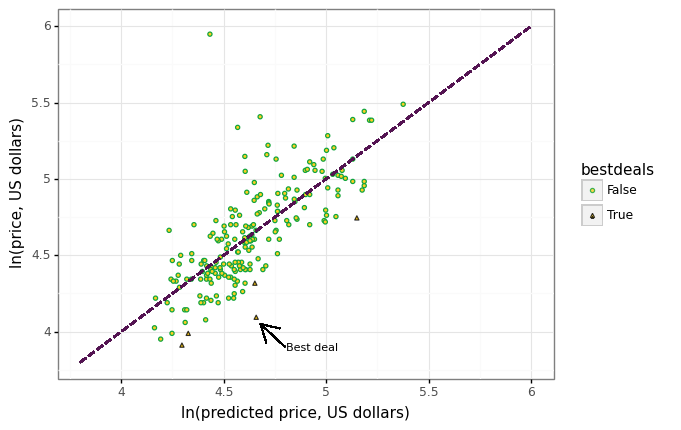

<ggplot: (325752540)>

In [36]:
y_yhat_hotels = (ggplot(data=hotels)
 + geom_point(aes(x='lnprice_hat',y='lnprice',color='bestdeals',shape='bestdeals'),size=1.2, fill=color[3],alpha=0.8,)
 + geom_segment(aes(x = 3.8, y = 3.8, xend = 6, yend =6), size=0.8, color=color[2],linetype='dashed')
 + labs(x = "ln(predicted price, US dollars) ",y = "ln(price, US dollars)")
 + scale_colour_manual(name='',values=[color[1],'black']) 
 + geom_segment(aes(x = 4.8, y = 3.9, xend = 4.68, yend = 4.05), arrow = arrow())
 + annotate("text", x = 4.93, y = 3.9, label = "Best deal", size=8)
 + theme_bw()
)
y_yhat_hotels

/usr/local/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


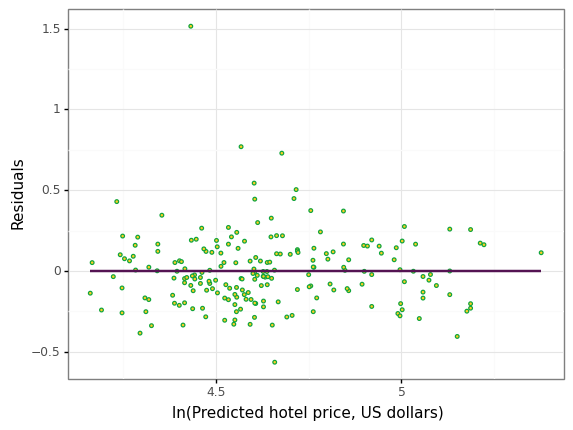

<ggplot: (325646990)>

In [37]:
y_hat_resid_hotels = (ggplot(data=hotels)
 + geom_point(aes(x='lnprice_hat',y='lnprice_resid'),color=color[1],size=1, fill=color[3],alpha=0.6)
 + geom_smooth(aes(x='lnprice_hat',y='lnprice_resid'),method='lm',color=color[2],size=1,se=False)
 + labs(x = "ln(Predicted hotel price, US dollars)",y = "Residuals")
 + scale_colour_manual(name='',values=[color[1],'black']) 
 + theme_bw()
)
y_hat_resid_hotels